In [1]:
import os
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image

import torch
import torch.nn as nn
from torchvision import transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models

torch.manual_seed(42)

### All in together

In [2]:
# Generating csv file to gather data of images 

def generate_csv(root,train = True, img_ext = 'jpg'):
    df = pd.DataFrame(columns = ['path', 'class'])
    for index,label in enumerate(os.listdir(root)):
            links = glob(f"{root}/{label}/*{img_ext}")
            temp_df = pd.DataFrame({'path': links, 'class': np.ones(len(links), dtype='float32')*index})
            df = pd.concat([df, temp_df], axis = 0)
        
    return df

In [3]:
data = generate_csv('C:\\Users\\ritth\\code\\Data\\datasciencebowl\\train\\train')
data.shape

(30336, 2)

In [4]:
transform = transforms.Compose([                                 
                                transforms.RandomRotation(90),
                                transforms.RandomResizedCrop(size=124),
                                transforms.ToTensor(),
                                transforms.Normalize(
                                    mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225]) 
                                ])

In [5]:
trainset = datasets.ImageFolder('C:\\Users\\ritth\\code\\Data\\datasciencebowl\\train\\train', transform = transform)
len(trainset.classes)

121

In [6]:
def load_image(path , H, W):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (H,W))
    return img

In [7]:
class PlanktonDataset(Dataset):
    def __init__(self, data, transform = None):
        super(PlanktonDataset, self).__init__()
        self.data = data
        self.height = 128
        self.width = 128
        self.transform = transform
    
    def __getitem__(self, index):
        # This method should return only 1 sample and label 
        # (according to "index"), not the whole dataset
        # So probably something like this for you:
        path = self.df.iloc[index, 0]
        img = load_image(path, self.height, self.width)
        label = self.df.iloc[index, 1]
        img = Image.fromarray(img)
        
        return (img, (label, path))
        
    def __len__(self):
        return len(self.data)
    
    

In [8]:
train_ds = PlanktonDataset(data, transform = transform)

In [9]:

indices = list(range(len(train_ds)))
split = int(0.2 * len(train_ds))
train_ds, test_ds = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_loader = DataLoader(train_ds, batch_size = 64, shuffle = True)
test_loader = DataLoader(train_ds, batch_size = 64, shuffle = False)


In [10]:
print(f"Size of train dataset : {train_ds.__len__()}")
print(f"Size of validation dataset : {test_ds.__len__()}")

Size of train dataset : 24269
Size of validation dataset : 6067


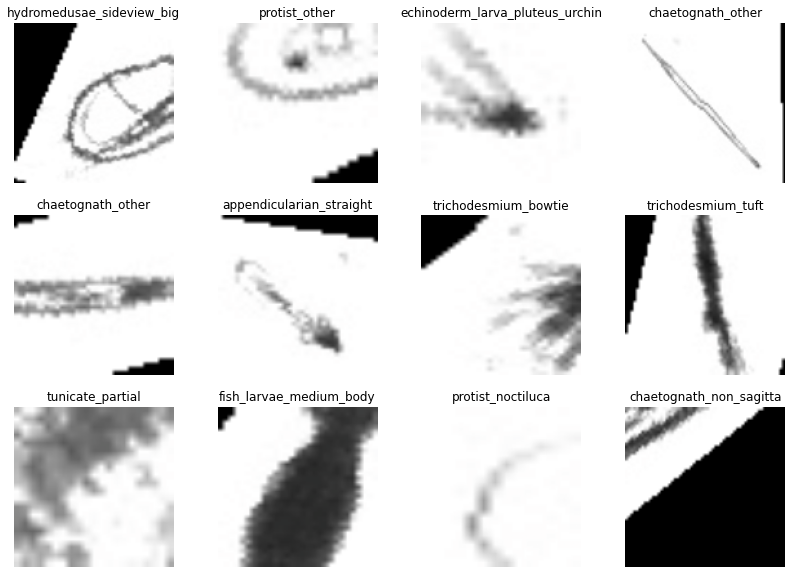

In [11]:
inv_normalize =  transforms.Normalize(
    mean=-1*np.divide([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
    std=1/np.array([0.229, 0.224, 0.225])
)

def class_plot(data , classes ,inv_normalize = None,n_figures = 12):
    n_row = int(n_figures/4)
    fig,axes = plt.subplots(figsize=(14, 10), nrows = n_row, ncols=4)
    for ax in axes.flatten():
        idx = np.random.randint(len(data))
        image,label = data[idx]
        label = int(label)
        l = classes[label]
        if(inv_normalize!=None):
            image = inv_normalize(image)
        image = image.numpy().transpose(1,2,0)
        im = ax.imshow(image)
        ax.set_title(l)
        ax.axis('off')
    plt.show()
class_plot(trainset,trainset.classes,inv_normalize)

In [12]:
class Conv(nn.Module):
    def __init__(self, in_channels, out_channels, kerel_size = 3, stride = 1, padding = 0):
        super(Conv, self).__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kerel_size, stride, padding),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
        )
    def forward(self, x):
        return self.seq(x)

class PlankNet(nn.Module):
    def __init__(self, in_channels, num_classes, H = 128, W = 128):
        super(PlankNet, self).__init__()
        self.model = nn.Sequential(
            Conv(in_channels, 16, 4), #125
            nn.MaxPool2d(2), #62
            Conv(16, 32, 3), #60
            Conv(32, 64, 3), #58
            nn.Dropout(0.1),
            nn.MaxPool2d(2), # 29
            Conv(64, 128), # 27
            nn.Dropout(0.2),
            Conv(128, 64, 3), # 25
            Conv(64, 32, 3), # 23
            nn.Flatten(),
            nn.Linear(32*23*23 , 4096),
            nn.Linear(4096, num_classes),
        )
    def forward(self, x):
        return self.model(x)
num_classes = len(trainset.classes)
model = PlankNet(3, num_classes, 128, 128)

In [13]:
EPOCHS = 30
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(params = model.parameters(), lr = 1e-4)
train_loss = []
val_loss = []

In [14]:
#model = model.cuda()  # Putting the model inside GPU
best_loss = np.inf
for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1} : \n")
    TR_LOSS = 0.0
    VAL_LOSS = 0.0
    model.train()
    
    # Train Data Forward & Backward Pass
    
    for index, (train_patch, (labels, _)) in enumerate(train_loader):
        optim.zero_grad()
        
        op = model(train_patch)
        tloss = criterion(op, labels)
        TR_LOSS += tloss.item()
        train_loss.append(tloss.item())
        tloss.backward()
        optim.step()
        if index % 100 == 99:
            print(f"         Step {index + 1} Loss : {'%.4f'%(tloss.item())}")   
    model.eval()
    
    # Validation Checking ( Only Forward Pass )
    
    with torch.no_grad():
        for index, (val_patch, (labels, _)) in enumerate(test_loader):
            
            op = model(val_patch)
            vloss = criterion(op, labels)
            VAL_LOSS += vloss.item()
            val_loss.append(vloss.item())
    print(f"\n     Training Loss : {'%.4f'%(TR_LOSS)}  ||  Validation Loss : {'%.4f'%(VAL_LOSS)}\n")
    
    if VAL_LOSS < best_loss :      # Model Updationg
        print("Model Updation : Success!\n", 'green')
        torch.save(model, 'best_model.pth')
        best_loss = VAL_LOSS
    else:
        print("Model Updation : Failed!\n", 'red')
print('Training completed...', 'green')

Epoch 1 : 



ValueError: too many values to unpack (expected 2)

In [ ]:
learning_rate = 0.001
epochs = 1

optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate)
criterion = nn.CrossEntropyLoss()

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
benchmark_accuracy = 0.90

for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    running_accuracy = 0
    running_loss = 0

    # training
    for index, (train_patch, (labels, _)) in enumerate(train_loader):
        

        optimizer.zero_grad()

        # forward pass
        logits = model(train_patch)
        train_preds = torch.argmax(logits.detach(), dim=1)

        # loss
        train_loss = criterion(logits, labels)
        running_loss += train_loss.item()

        # train accuracy
        train_acc = (labels == train_preds).sum() / len(labels)
        running_accuracy += train_acc.item()

        # backward pass
        
        train_loss.backward()
        
        # update paramaters
        
        optimizer.step()

        # mean loss (all batches losses divided by the total number of batches)
    train_losses.append(running_loss / len(train_loader))
    
    # mean accuracies
    train_accuracies.append(running_accuracy / len(train_loader))
    
    # print
    print(f'Train loss: {train_losses[-1] :.4f}')

    # validation
    model.eval()
    with torch.no_grad():
        running_accuracy = 0
        running_loss = 0

        for index, (val_patch, (labels, _)) in enumerate(test_loader):
            
            # logits
            test_logits = model(val_patch)

            # predictions
            test_preds = torch.argmax(test_logits, dim=1)
            
            # accuracy
            test_acc = (labels == test_preds).sum() / len(labels)
            running_accuracy += test_acc.item()

            # loss
            test_loss = criterion(test_logits, labels)
            running_loss += test_loss.item()

        # mean accuracy for each epoch
        test_accuracies.append(running_accuracy / len(test_loader))

        # mean loss for each epoch
        test_losses.append(running_accuracy / len(test_loader))
        # print
        print(f'Test accuracy: {test_accuracies[-1]*100 :.2f}%')
        print('='*100)
        # saving best model
        # is current mean score (mean per epoch) greater than or equal to the benchmark?
        if test_accuracies[-1] > benchmark_accuracy:
            # save model to cpu
            torch.save(model.state_dict(), 'model.pth')

            # update benckmark
            benchmark_accuracy = test_accuracies[-1]

    model.train()


# Plots
x_epochs = list(range(epochs))
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(x_epochs, train_losses, marker='o', label='train')
plt.plot(x_epochs, test_losses, marker='o', label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x_epochs, train_accuracies, marker='o', label='train')
plt.plot(x_epochs, test_accuracies, marker='o', label='test')
plt.axhline(benchmark_accuracy, c='grey', ls='--',
            label=f'Best_accuracy({benchmark_accuracy*100 :.2f}%)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('./learning_curve.png', dpi = 200)

plt.show()